In [1]:
import re
import os 
import sys 

import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io

from pathlib import Path
from tqdm.notebook import trange, tqdm
from joblib import Parallel, delayed
from skimage import exposure
import h5py
import pandas as pd
import scanpy as sc
import anndata as ad
import squidpy as sq
sc.settings.verbosity = 3

from matplotlib.pyplot import rc_context
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from functools import reduce
from matplotlib import cm, colors
import scanorama
import seaborn as sns 


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / 'data' 

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

# Read masks

In [4]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "TS Donor A",
    "TS Donor E",
]

In [5]:
from skimage import morphology
import scipy.ndimage
from scipy.ndimage import distance_transform_edt

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "png" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

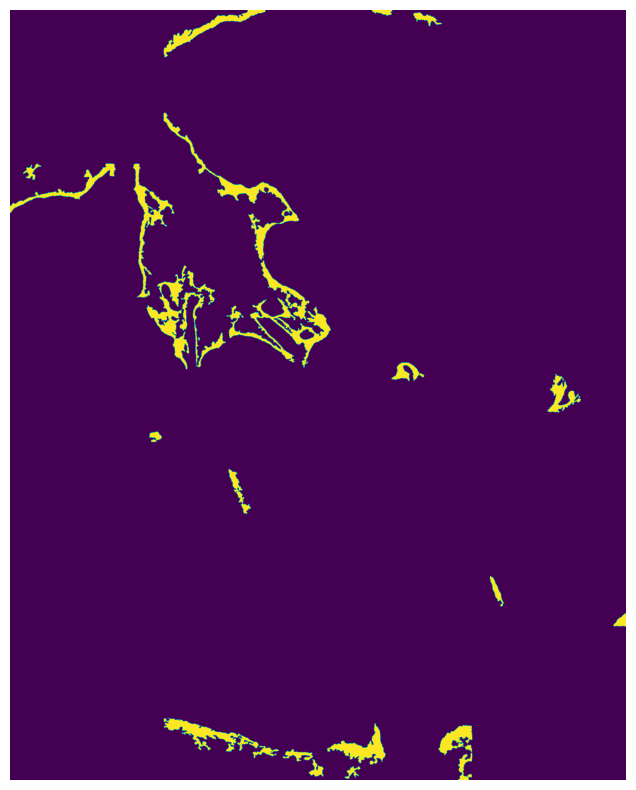

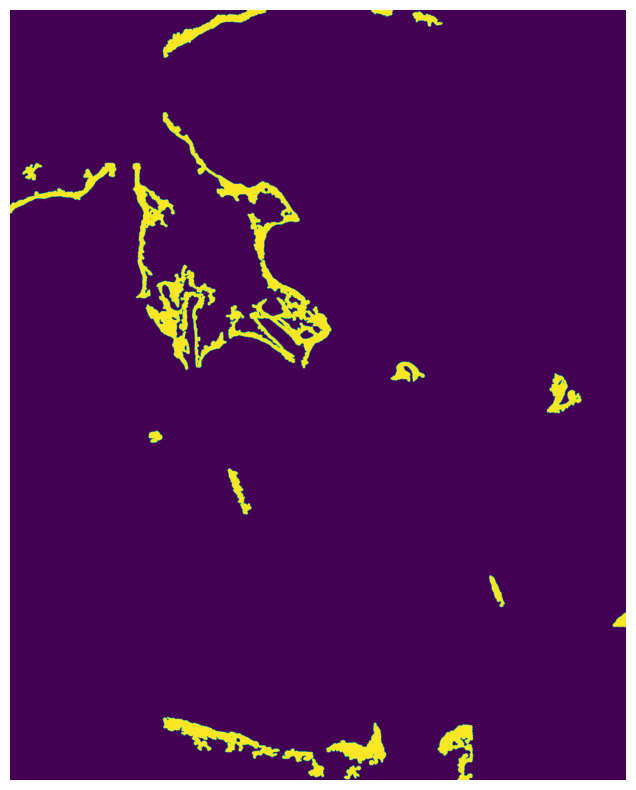

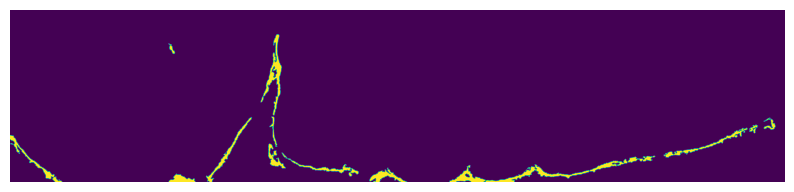

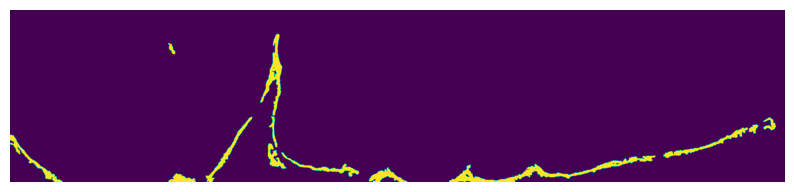

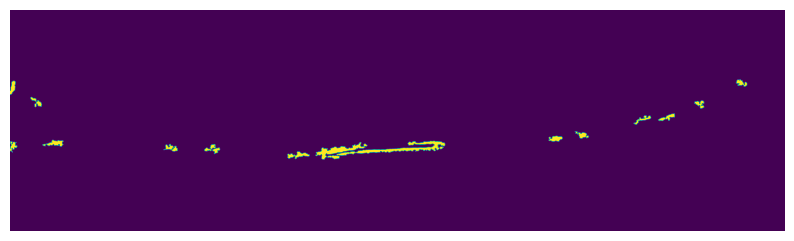

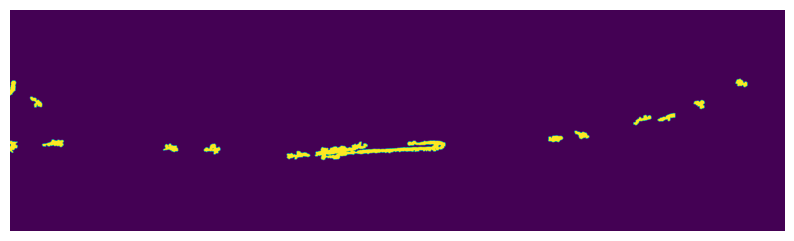

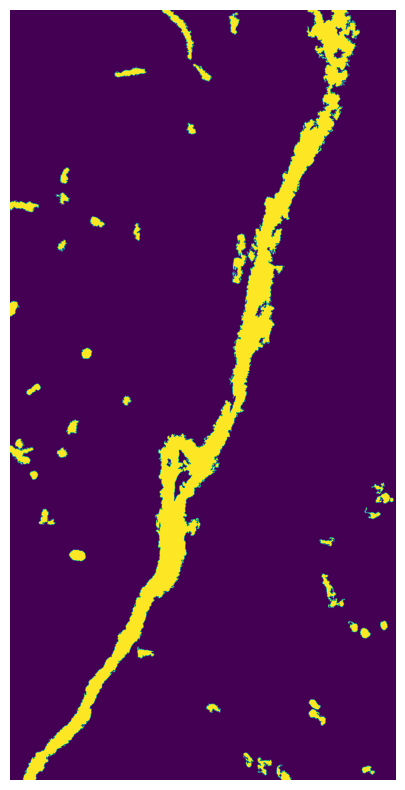

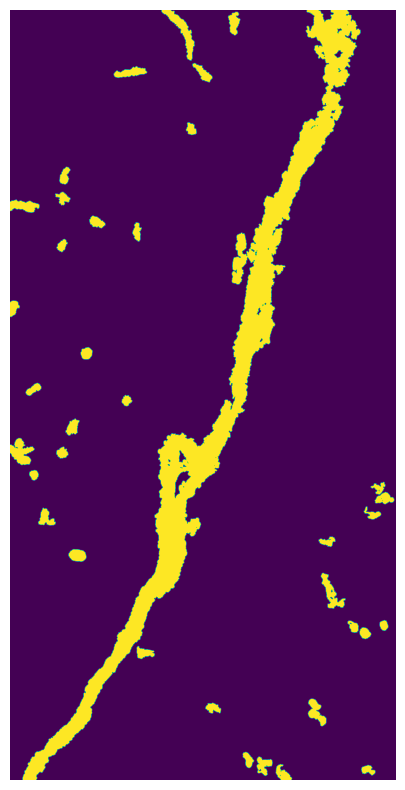

In [10]:
masks = get_masks(data_dir / "masks_col" )

for donor in donors:
    mask = masks[donor]
    mask_binary = mask==1
    mask_binary = morphology.remove_small_holes(mask_binary, 1000)
    mask_binary = morphology.remove_small_objects(mask_binary, 3000)
    
    skeleton = morphology.skeletonize(mask_binary)
    skeleton = expand_labels(mask_binary, distance=5)
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mask_binary)
    ax.axis('off')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(skeleton)
    ax.axis('off')
    
    plt.show()